# Capacity Tests

### Test 1: 

Sample Input: [..., #, #, A, B, C, D, E, #, #, #, X, B, C, D, Y, #, ... ]

Expected Output: The accuracy is around or greater than 0.5.


In [26]:
from SequentialGroup import Column, Group, Node, Link
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.Profiler import Profiler
from typing import Set
from utils.dataset import generate_dataset
from utils.draw_group import draw_group

figures_root = Path('Figures')


In [2]:
seq1 = ['A', 'B', 'C', 'D', 'E']
seq2 = ['X', 'B', 'C', 'D', 'Y']
seqs = [seq1, seq2]

D_train, _, dictionary = generate_dataset(seqs)
data = D_train[:5000]

In [27]:
def create_model(n_columns, n_nodes):
    # Create the model
    g = Group(n_columns, n_nodes)
    g.thresh = 0.8
    g.p_plus = 2 #1.95
    g.p_minus = 0.99 #0.9
    g.p_minus2 = 0.01

    for idx, column in enumerate(g.columns):
        column.mark = idx
    return g

def test_model(g: Group, data, top1=False):
    print(len(data))
    print(data[:20])
    accuracies = []
    n_anticipations = []

    profiler = Profiler(100)
    for i, (idx, idx_next) in enumerate((tqdm(zip(data[:-1], data[1:]), total=len(data)-1))):
        candidates: Set[Node] = g.activate(idx)
        anticipations = set()
        if not top1:
            for candidate in candidates:
                anticipations.add(candidate.column.mark)
        else:
            if len(candidates) > 0:
                candidate = max(candidates, key=lambda node: node.activity_pred)
                anticipations.add(candidate.column.mark)

        ''' compute the accuracy '''
        acc = profiler.observe(anticipations, idx_next)
        accuracies.append(acc)
        ''' count the number of valid anticipations '''
        a = np.array(g.columns[idx].get_activities(), dtype=bool)
        if not all(a):
            n_anticipations.append((len(anticipations), sum(a)))
        # n_anticipations.append(len(anticipations))
        
    return accuracies, g, n_anticipations

In [28]:
def plot_curve(y, color='#1F77B4', color2="#82B0D2", window_size = 1000, y_bottom=None, y_top=None, label=None):
    s = pd.Series(y)
    s_ma = s.rolling(window=window_size, min_periods=1).mean()
    upper_quartile = s.rolling(window=window_size, min_periods=1).quantile(0.75)
    lower_quartile = s.rolling(window=window_size, min_periods=1).quantile(0.25)
    plt.plot(s, c=color2, alpha=0.3, zorder=2)
    plt.fill_between(s.index, lower_quartile, upper_quartile, color=color2, zorder=4)
    plt.plot(s_ma, color=color, label=label, zorder=6)
    plt.ylim(bottom=y_bottom, top=y_top)

In [16]:
g1 = create_model(26, 10)
# accuracies1, _, n_anticipations1 = test_model(g1, data)
filename = Path('cache')/f"result-simple-case.pkl"
if not filename.exists():
    # accuracies, g, n_anticipations = test_capacity(length, n_patterns, n_types, n_nodes)
    accuracies, _, n_anticipations = test_model(g1, data)
    with open(str(filename), 'wb') as f:
        pickle.dump((accuracies, n_anticipations), f)
else:
    with open(str(filename), 'rb') as f:
        accuracies, n_anticipations = pickle.load(f)
accuracies1, n_anticipations1 = accuracies, n_anticipations

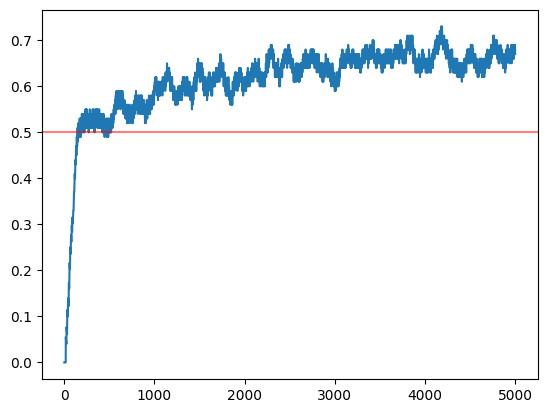

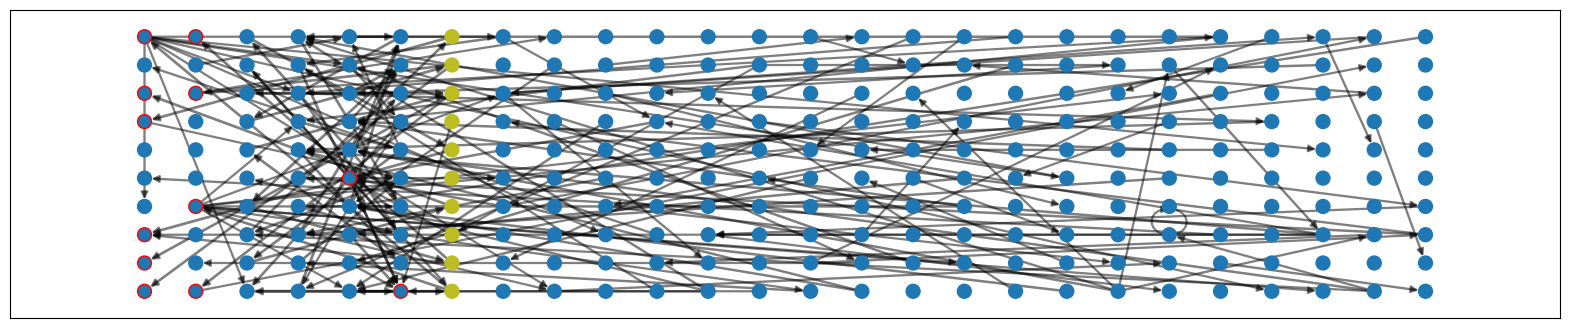

In [6]:
plt.figure()
plt.plot(accuracies1)
plt.axhline(0.5, c='r', alpha=0.5)
draw_group(g1)
plt.show()

In [7]:
g1_2 = create_model(26, 10)
accuracies1_2, _, n_anticipations1_2 = test_model(g1_2, data, top1=True)

5000
[3, 5, 2, 6, 0, 6, 13, 19, 3, 5, 2, 6, 0, 11, 14, 1, 4, 5, 2, 6]


100%|██████████| 4999/4999 [00:00<00:00, 9816.91it/s] 


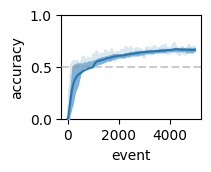

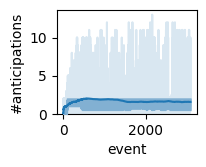

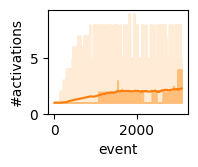

In [29]:
plt.figure(figsize=(2,1.6))
plt.subplots_adjust(left=0.3, right=1.0, top=0.95, bottom=0.3)
plot_curve(accuracies1[:50000], y_bottom=0, y_top=1, label="all")
plt.axhline(0.5, color='#999999', alpha=0.5, linestyle='--', zorder=5)
# plot_curve(accuracies1_2[:50000], color="#2CA02C", color2="#8ECFC9", y_bottom=0, y_top=1, label="Top1")
# plt.legend(loc='upper right')
plt.ylabel("accuracy")
plt.xlabel("event")
plt.savefig(figures_root/"Capacity"/f"Accuracy-SimpleCase.pdf")
plt.savefig(figures_root/"Capacity/svgs"/f"Accuracy-SimpleCase.svg")

plt.figure(figsize=(2,1.6))
plt.subplots_adjust(left=0.3, right=1.0, top=0.95, bottom=0.3)
plot_curve((pair[0]/pair[1] for pair in n_anticipations1[:50000]), y_bottom=0)
# plt.axhline(1, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plt.ylabel("#anticipations")
plt.xlabel("event")
plt.savefig(figures_root/"Capacity"/f"Anticipations-SimpleCase.pdf")
plt.savefig(figures_root/"Capacity/svgs"/f"Anticipations-SimpleCase.svg")

plt.figure(figsize=(2,1.6))
plt.subplots_adjust(left=0.3, right=1.0, top=0.95, bottom=0.3)
plot_curve((pair[1] for pair in n_anticipations1[:50000]), color="#FF7F0E", color2="#FFBE7A", y_bottom=0)
# plt.axhline(1, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plt.ylabel("#activations")
plt.xlabel("event")
plt.savefig(figures_root/"Capacity"/f"Activations-SimpleCase.pdf")
plt.savefig(figures_root/"Capacity/svgs"/f"Activations-SimpleCase.svg")
plt.show()

### Test 2: 

Randomly generate some patterns of sequence.

Sample Input: length=5, n_seqs = 5

Sample Generated data: [..., #, #, X, B, A, E, K, #, #, #, I, S, L, Q, J, #, #, #, L, K, M, B, Z, #, #, #, C, V, W, T, P, #, #, #, O, H, B, X, E, #, ...]

Expected Output: The accuracy is around or greater than 0.5.

In [9]:
"""Helpers"""
def generate_seqs(length, n_patterns, n_types=26):
    from ordered_set import OrderedSet
    length = int(length)
    n_patterns = int(n_patterns)
    assert (n_patterns >= 1) and (length >= 4)
    seqs = [] # subsequences
    for _ in range(n_patterns):
        samples = OrderedSet([i for i in range(n_types)])
        seq = list(np.random.choice(samples, length))
        seqs.append(seq)
    return seqs

def test_capacity(length, n_patterns, n_types=26, n_nodes=10):
    root_cache = Path('./cache')
    root_cache.mkdir(parents=True, exist_ok=True)
    file_cache = root_cache/f"dataset_capacity-test_{length}_{n_patterns}_{n_types}.pkl"
    if not file_cache.exists():
        seqs = generate_seqs(length, n_patterns, n_types)
        D_train, D_test, dictionary = generate_dataset(seqs, length*n_patterns*200, 1000, n_chars=n_types)
        with open(file_cache, 'wb') as f:
            pickle.dump((D_train, D_test, dictionary), f)
    else:
        with open(file_cache, "rb") as f:
            D_train, D_test, dictionary = pickle.load(f)
    data = D_train[:length*n_patterns*400]
    g = create_model(n_types, n_nodes)
    accuracies, _, n_anticipations = test_model(g, data)
    return accuracies, g, n_anticipations

#### length=5, n_patterns=5, n_types=26

In [10]:
# accuracies2, g2, n_anticipations2 = test_capacity(5, 5, 26, 10)
length = 5
n_episodes = 5
n_types = 26
n_nodes=10
filename = Path('cache')/f"result-length={length}-n_patterns={n_episodes}-n_types={n_types}-n_nodes={n_nodes}.pkl"
if not filename.exists():
    accuracies, g, n_anticipations = test_capacity(length, n_episodes, n_types, n_nodes)
    with open(str(filename), 'wb') as f:
        pickle.dump((accuracies, n_anticipations), f)
else:
    with open(str(filename), 'rb') as f:
        accuracies, n_anticipations = pickle.load(f)
accuracies2, n_anticipations2 = accuracies, n_anticipations

10000
[4, 2, 6, 13, 7, 16, 11, 14, 1, 9, 16, 11, 5, 9, 22, 22, 1, 9, 16, 11]


100%|██████████| 9999/9999 [00:01<00:00, 6589.87it/s] 


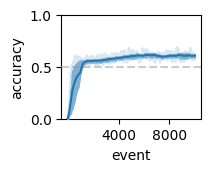

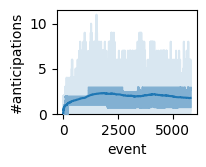

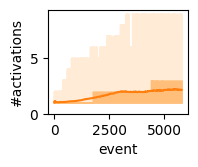

In [20]:
plt.figure(figsize=(2,1.6))
plt.subplots_adjust(left=0.3, right=1.0, top=0.95, bottom=0.3)
plot_curve(accuracies2[:50000], y_bottom=0, y_top=1)
plt.axhline(0.5, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plt.xticks([4000,8000])
plt.ylabel("accuracy")
plt.xlabel("event")
plt.savefig(figures_root/"Capacity"/f"Accuracy-length=5-n_patterns=5-n_types=26-n_nodes=10.pdf")
plt.savefig(figures_root/"Capacity/svgs"/f"Accuracy-length=5-n_patterns=5-n_types=26-n_nodes=10.svg")

plt.figure(figsize=(2,1.6))
plt.subplots_adjust(left=0.3, right=1.0, top=0.95, bottom=0.3)
plot_curve((pair[0]/pair[1] for pair in n_anticipations2[:50000]), y_bottom=0)
# plt.axhline(1, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plt.ylabel("#anticipations")
plt.xlabel("event")
plt.savefig(figures_root/"Capacity"/f"Anticipations-length=5-n_patterns=5-n_types=26-n_nodes=10.pdf")
plt.savefig(figures_root/"Capacity/svgs"/f"Anticipations-length=5-n_patterns=5-n_types=26-n_nodes=10.svg")

plt.figure(figsize=(2,1.6))
plt.subplots_adjust(left=0.3, right=1.0, top=0.95, bottom=0.3)
plot_curve((pair[1] for pair in n_anticipations2[:50000]), color="#FF7F0E", color2="#FFBE7A", y_bottom=0)
# plt.axhline(1, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plt.ylabel("#activations")
plt.xlabel("event")
plt.savefig(figures_root/"Capacity"/f"Activations-length=5-n_patterns=5-n_types=26-n_nodes=10.pdf")
plt.savefig(figures_root/"Capacity/svgs"/f"Activations-length=5-n_patterns=5-n_types=26-n_nodes=10.svg")
plt.show()

#### length=14, n_patterns=20, n_types=26

In [12]:
# accuracies3, g3, n_anticipations3 = test_capacity(14, 20, 26, 10)
length = 14
n_episodes = 20
n_types = 26
n_nodes=10
filename = Path('cache')/f"result-length={length}-n_patterns={n_episodes}-n_types={n_types}-n_nodes={n_nodes}.pkl"
if not filename.exists():
    accuracies, g, n_anticipations = test_capacity(length, n_episodes, n_types, n_nodes)
    with open(str(filename), 'wb') as f:
        pickle.dump((accuracies, n_anticipations), f)
else:
    with open(str(filename), 'rb') as f:
        accuracies, n_anticipations = pickle.load(f)
accuracies3, n_anticipations3 = accuracies, n_anticipations

112000
[10, 2, 20, 14, 15, 10, 0, 1, 17, 12, 14, 20, 8, 5, 13, 19, 16, 11, 14, 1]


100%|██████████| 111999/111999 [00:47<00:00, 2375.56it/s]


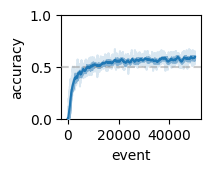

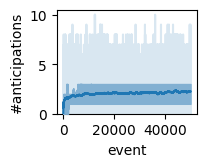

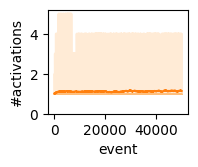

In [21]:
plt.figure(figsize=(2,1.6))
plt.subplots_adjust(left=0.3, right=1.0, top=0.95, bottom=0.3)
plot_curve(accuracies3[:50000], y_bottom=0, y_top=1)
plt.axhline(0.5, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plt.ylabel("accuracy")
plt.xlabel("event")
plt.savefig(figures_root/"Capacity"/f"Accuracy-length=14-n_patterns=20-n_types=26-n_nodes=10.pdf")
plt.savefig(figures_root/"Capacity/svgs"/f"Accuracy-length=14-n_patterns=20-n_types=26-n_nodes=10.svg")

plt.figure(figsize=(2,1.6))
plt.subplots_adjust(left=0.3, right=1.0, top=0.95, bottom=0.3)
plot_curve((pair[0]/pair[1] for pair in n_anticipations3[:50000]), y_bottom=0)
# plt.axhline(1, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plt.ylabel("#anticipations")
plt.xlabel("event")
plt.savefig(figures_root/"Capacity"/f"Anticipations-length=14-n_patterns=20-n_types=26-n_nodes=10.pdf")
plt.savefig(figures_root/"Capacity/svgs"/f"Anticipations-length=14-n_patterns=20-n_types=26-n_nodes=10.svg")

plt.figure(figsize=(2,1.6))
plt.subplots_adjust(left=0.3, right=1.0, top=0.95, bottom=0.3)
plot_curve((pair[1] for pair in n_anticipations3[:50000]), color="#FF7F0E", color2="#FFBE7A", y_bottom=0)
# plt.axhline(1, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plt.ylabel("#activations")
plt.xlabel("event")
plt.savefig(figures_root/"Capacity"/f"Activations-length=14-n_patterns=20-n_types=26-n_nodes=10.pdf")
plt.savefig(figures_root/"Capacity/svgs"/f"Activations-length=14-n_patterns=20-n_types=26-n_nodes=10.svg")
plt.show()

#### length=14, n_patterns=20, n_types=1000 (26 by default)

In [14]:
# accuracies4, g4, n_anticipations4 = test_capacity(14, 20, 1000, 10)
length = 14
n_episodes = 20
n_types = 1000
n_nodes=10
filename = Path('cache')/f"result-length={length}-n_patterns={n_episodes}-n_types={n_types}-n_nodes={n_nodes}.pkl"
if not filename.exists():
    accuracies, g, n_anticipations = test_capacity(length, n_episodes, n_types, n_nodes)
    with open(str(filename), 'wb') as f:
        pickle.dump((accuracies, n_anticipations), f)
else:
    with open(str(filename), 'rb') as f:
        accuracies, n_anticipations = pickle.load(f)
accuracies4, n_anticipations4 = accuracies, n_anticipations

112000
[231, 205, 218, 161, 111, 94, 158, 75, 7, 121, 201, 52, 139, 175, 589, 147, 240, 331, 334, 129]


100%|██████████| 111999/111999 [01:35<00:00, 1171.77it/s]


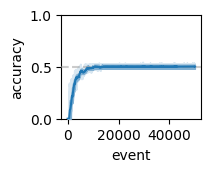

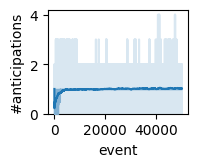

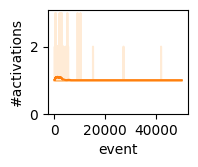

In [23]:
plt.figure(figsize=(2,1.6))
plt.subplots_adjust(left=0.3, right=1.0, top=0.95, bottom=0.3)
plot_curve(accuracies4[:50000], y_bottom=0, y_top=1)
plt.axhline(0.5, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plt.ylabel("accuracy")
plt.xlabel("event")
plt.savefig(figures_root/"Capacity"/f"Accuracy-length=14-n_patterns=20-n_types=1000-n_nodes=10.pdf")
plt.savefig(figures_root/"Capacity/svgs"/f"Accuracy-length=14-n_patterns=20-n_types=1000-n_nodes=10.svg")

plt.figure(figsize=(2,1.6))
plt.subplots_adjust(left=0.3, right=1.0, top=0.95, bottom=0.3)
plot_curve((pair[0]/pair[1] for pair in n_anticipations4[:50000]), y_bottom=0)
# plt.axhline(1, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plt.ylabel("#anticipations")
plt.xlabel("event")
plt.savefig(figures_root/"Capacity"/f"Anticipations-length=14-n_patterns=20-n_types=1000-n_nodes=10.pdf")
plt.savefig(figures_root/"Capacity/svgs"/f"Anticipations-length=14-n_patterns=20-n_types=1000-n_nodes=10.svg")

plt.figure(figsize=(2,1.6))
plt.subplots_adjust(left=0.3, right=1.0, top=0.95, bottom=0.3)
plot_curve((pair[1] for pair in n_anticipations4[:50000]), color="#FF7F0E", color2="#FFBE7A", y_bottom=0)
# plt.axhline(1, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plt.ylabel("#activations")
plt.xlabel("event")
plt.savefig(figures_root/"Capacity"/f"Activations-length=14-n_patterns=20-n_types=1000-n_nodes=10.pdf")
plt.savefig(figures_root/"Capacity/svgs"/f"Activations-length=14-n_patterns=20-n_types=1000-n_nodes=10.svg")
plt.show()

# Catastrophic-Forgetting Tests

In [87]:
def test_catastrophic_forgetting(length, n_patterns, n_nodes=16, n_types=26, n_episodes=3, n_repeats=5, n_samples=50):
    ''''''
    # Create the model
    g = create_model(n_types, n_nodes)

    accuracies = []
    n_anticipations = []
    datasets = {}

    profiler = Profiler(100)

    for i_repeat in range(n_repeats):
        print(f'repeat: {i_repeat+1}/{n_repeats}')
        for i_episode in range(n_episodes):
            # prepare data
            root_cache = Path('./cache')
            root_cache.mkdir(parents=True, exist_ok=True)
            file_cache = root_cache/f"dataset_catastrophic_fogetting-test_{length}_{n_patterns}_{n_types}_{i_episode}.pkl"
            n_data = length*n_patterns*n_samples

            if file_cache not in datasets:
                if not file_cache.exists():
                    seqs = generate_seqs(length, n_patterns, n_types)
                    D_train, D_test, dictionary = generate_dataset(seqs, length*n_episodes*200, 1000, n_chars=n_types)
                    # D_train, D_test, dictionary = generate_dataset(length, number, n_chars=n_chars, n_train=length*number*200)
                    with open(file_cache, 'wb') as f:
                        pickle.dump((D_train, D_test, dictionary), f)
                else:
                    with open(file_cache, "rb") as f:
                        D_train, D_test, dictionary = pickle.load(f)
                
                datasets[file_cache] = [D_train, n_data]
                data = D_train[:n_data]
            else:
                D_train, cnt = datasets[file_cache]
                if cnt+n_data <= len(D_train):
                    data = D_train[cnt:cnt+n_data]
                else:
                    data = list(*D_train[cnt:], D_train[:cnt+n_data-len(D_train)])

            # start learning
            for i, (idx, idx_next) in enumerate((tqdm(zip(data[:-1], data[1:]), total=len(data)-1, desc=f"episode: {i_episode+1}/{n_episodes}"))):
                candidates: Set[Node] = g.activate(idx)
                anticipations = set()

                for candidate in candidates:
                    anticipations.add(candidate.column.mark)

                ''' compute the accuracy '''
                acc = profiler.observe(anticipations, idx_next)
                accuracies.append(acc)
                ''' count the number of valid anticipations '''
                a = np.array(g.columns[idx].get_activities(), dtype=bool)
                if not all(a):
                    n_anticipations.append((len(anticipations), sum(a)))
                # n_anticipations.append(len(anticipations))
        
    return accuracies, g, n_anticipations


In [49]:
n_episodes = 3
n_repeats = 3
length=10
n_patterns = 10
n_samples = 200
accuracies_cf, g_cf, n_anticipations_cf = test_catastrophic_forgetting(length, n_patterns, 16, n_episodes=n_episodes, n_repeats=n_repeats, n_samples=n_samples)

repeat: 1/3


episode: 3/3: 100%|██████████| 19999/19999 [00:11<00:00, 1807.37it/s]


repeat: 2/3


episode: 3/3: 100%|██████████| 19999/19999 [00:11<00:00, 1696.64it/s]


repeat: 3/3


episode: 3/3: 100%|██████████| 19999/19999 [00:13<00:00, 1451.05it/s]


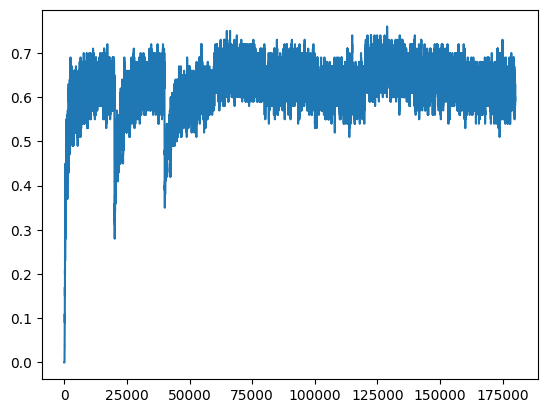

In [50]:
plt.figure()
plt.plot(accuracies_cf)
# draw_group(g_cf)
plt.show()

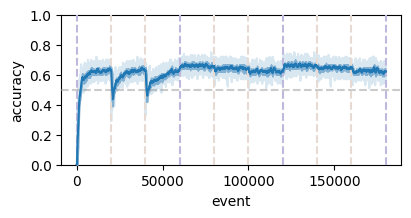

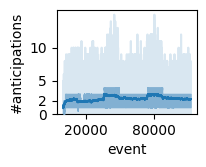

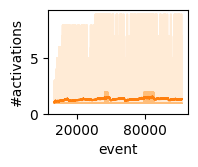

In [118]:
plt.figure(figsize=(4,2))
# plt.figure()
plt.subplots_adjust(left=0.15, right=1.0, top=0.95, bottom=0.2)
plot_curve(accuracies_cf, y_bottom=0, y_top=1, label="all")
plt.axhline(0.5, color='#999999', alpha=0.5, linestyle='--', zorder=5)
period = length*n_patterns*n_samples
for i in range(0, n_repeats*n_episodes+1):
    if i%n_episodes == 0:
        # plt.axvline(period*i, color='r', alpha=0.5, linestyle='--', zorder=5)
        plt.axvline(period*i, color='#BEB8DC', alpha=1, linestyle='--', zorder=5)
    else:
        # plt.axvline(period*i, color='g', alpha=0.5, linestyle='--', zorder=5)
        plt.axvline(period*i, color='#E7DAD2', alpha=1, linestyle='--', zorder=5)
plt.ylabel("accuracy")
plt.xlabel("event")
plt.xticks([0, 50000, 100000, 150000])
plt.savefig(figures_root/"CatastrophicForgetting"/f"Accuracy-length={length}-n_patterns={n_patterns}-n_types={26}-n_nodes={16}-n_repeats={n_repeats}-n_episodes={n_episodes}.pdf")
plt.savefig(figures_root/"CatastrophicForgetting/svgs"/f"Accuracy-length={length}-n_patterns={n_patterns}-n_types={26}-n_nodes={16}-n_repeats={n_repeats}-n_episodes={n_episodes}.svg")

plt.figure(figsize=(2,1.6))
plt.subplots_adjust(left=0.3, right=1.0, top=0.95, bottom=0.3)
plot_curve((pair[0]/pair[1] for pair in n_anticipations_cf), y_bottom=0)
# plt.axhline(1, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plt.yticks([0,2,5,10])
plt.ylabel("#anticipations")
plt.xlabel("event")
plt.xticks([20000, 80000])
plt.savefig(figures_root/"CatastrophicForgetting"/f"Anticipations-length={length}-n_patterns={n_patterns}-n_types={26}-n_nodes={16}-n_repeats={n_repeats}-n_episodes={n_episodes}.pdf")
plt.savefig(figures_root/"CatastrophicForgetting/svgs"/f"Anticipations-length={length}-n_patterns={n_patterns}-n_types={26}-n_nodes={16}-n_repeats={n_repeats}-n_episodes={n_episodes}.svg")

plt.figure(figsize=(2,1.6))
plt.subplots_adjust(left=0.3, right=1.0, top=0.95, bottom=0.3)
plot_curve((pair[1] for pair in n_anticipations_cf), color="#FF7F0E", color2="#FFBE7A", y_bottom=0)
# plt.axhline(1, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plt.ylabel("#activations")
plt.xlabel("event")
plt.xticks([20000, 80000])
plt.savefig(figures_root/"CatastrophicForgetting"/f"Activations-length={length}-n_patterns={n_patterns}-n_types={26}-n_nodes={16}-n_repeats={n_repeats}-n_episodes={n_episodes}.pdf")
plt.savefig(figures_root/"CatastrophicForgetting/svgs"/f"Activations-length={length}-n_patterns={n_patterns}-n_types={26}-n_nodes={16}-n_repeats={n_repeats}-n_episodes={n_episodes}.svg")

plt.show()

In [115]:
n_episodes = 3
n_repeats = 3
length=10
n_patterns = 10
n_samples = 200
n_types=1000
accuracies_cf2, g_cf2, n_anticipations_cf2 = test_catastrophic_forgetting(length, n_patterns, 16, n_episodes=n_episodes, n_repeats=n_repeats, n_samples=n_samples, n_types=n_types)

repeat: 1/3


episode: 3/3: 100%|██████████| 19999/19999 [00:17<00:00, 1156.46it/s]


repeat: 2/3


episode: 3/3: 100%|██████████| 19999/19999 [00:18<00:00, 1096.66it/s]


repeat: 3/3


episode: 3/3: 100%|██████████| 19999/19999 [00:19<00:00, 1044.83it/s]


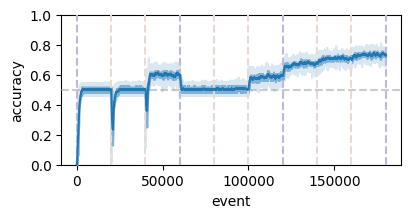

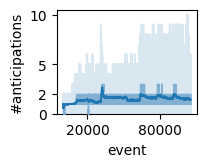

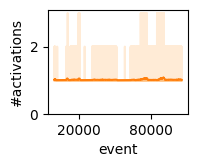

In [117]:
plt.figure(figsize=(4,2))
# plt.figure()
plt.subplots_adjust(left=0.15, right=1.0, top=0.95, bottom=0.2)
plot_curve(accuracies_cf2, y_bottom=0, y_top=1, label="all")
plt.axhline(0.5, color='#999999', alpha=0.5, linestyle='--', zorder=5)
period = length*n_patterns*n_samples
for i in range(0, n_repeats*n_episodes+1):
    if i%n_episodes == 0:
        # plt.axvline(period*i, color='r', alpha=0.5, linestyle='--', zorder=5)
        plt.axvline(period*i, color='#BEB8DC', alpha=1, linestyle='--', zorder=5)
    else:
        # plt.axvline(period*i, color='g', alpha=0.5, linestyle='--', zorder=5)
        plt.axvline(period*i, color='#E7DAD2', alpha=1, linestyle='--', zorder=5)
plt.ylabel("accuracy")
plt.xlabel("event")
plt.xticks([0, 50000, 100000, 150000])
plt.savefig(figures_root/"CatastrophicForgetting"/f"Accuracy-length={length}-n_patterns={n_patterns}-n_types={n_types}-n_nodes={16}-n_repeats={n_repeats}-n_episodes={n_episodes}.pdf")
plt.savefig(figures_root/"CatastrophicForgetting/svgs"/f"Accuracy-length={length}-n_patterns={n_patterns}-n_types={n_types}-n_nodes={16}-n_repeats={n_repeats}-n_episodes={n_episodes}.svg")

plt.figure(figsize=(2,1.6))
plt.subplots_adjust(left=0.3, right=1.0, top=0.95, bottom=0.3)
plot_curve((pair[0]/pair[1] for pair in n_anticipations_cf2), y_bottom=0)
# plt.axhline(1, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plt.yticks([0,2,5,10])
plt.ylabel("#anticipations")
plt.xlabel("event")
plt.xticks([20000, 80000])
plt.savefig(figures_root/"CatastrophicForgetting"/f"Anticipations-length={length}-n_patterns={n_patterns}-n_types={n_types}-n_nodes={16}-n_repeats={n_repeats}-n_episodes={n_episodes}.pdf")
plt.savefig(figures_root/"CatastrophicForgetting/svgs"/f"Anticipations-length={length}-n_patterns={n_patterns}-n_types={n_types}-n_nodes={16}-n_repeats={n_repeats}-n_episodes={n_episodes}.svg")

plt.figure(figsize=(2,1.6))
plt.subplots_adjust(left=0.3, right=1.0, top=0.95, bottom=0.3)
plot_curve((pair[1] for pair in n_anticipations_cf2), color="#FF7F0E", color2="#FFBE7A", y_bottom=0)
# plt.axhline(1, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plt.ylabel("#activations")
plt.xlabel("event")
plt.xticks([20000, 80000])
plt.savefig(figures_root/"CatastrophicForgetting"/f"Activations-length={length}-n_patterns={n_patterns}-n_types={n_types}-n_nodes={16}-n_repeats={n_repeats}-n_episodes={n_episodes}.pdf")
plt.savefig(figures_root/"CatastrophicForgetting/svgs"/f"Activations-length={length}-n_patterns={n_patterns}-n_types={n_types}-n_nodes={16}-n_repeats={n_repeats}-n_episodes={n_episodes}.svg")

plt.show()